In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Helvetica"],
# })
sns.set_theme(context='talk')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

In [2]:


from scipy.optimize import least_squares, root_scalar
#given one of these three functions, find all the solutions
def find_yc(UN, R0, scaled_dbar, m_func, tol=1e-1):
    starting_points = [1e-3,1]  # or whatever range is sane
    solutions = []

    for yc0 in starting_points:
        try:
            sol = so.fsolve(lambda yc: m_func(UN, yc, R0, scaled_dbar) - 1, yc0)
            yc_sol = sol[0] 
            # print('solution', yc_sol)

            residual = np.abs(m_func(UN, yc_sol, R0, scaled_dbar) - 1)
            # print('residual', residual)
            
            if residual < tol:
                if not any(np.isclose(yc_sol, s, atol=tol) for s in solutions):
                    solutions.append(yc_sol)
        except Exception as e:
            print(e)
            pass

    return ([np.array([UN, yc]) for yc in solutions])

def find_yc_least_squares(UN, R0, scaled_dbar, m_func, tol=1e-3):
    starting_points = np.geomspace(1e-4, 10, 50)  # wide + positive
    solutions = []

    for yc0 in starting_points:
        res = least_squares(
            lambda yc: m_func(UN, yc[0], R0, scaled_dbar) - 1,
            x0=[yc0],
            bounds=(0, 10),
            xtol=1e-3,
            ftol=1e-3,
        )

        if res.success:
            yc_sol = res.x[0]
            residual = abs(m_func(UN, yc_sol, R0, scaled_dbar) - 1)
            if residual < tol:
                if not any(np.isclose(yc_sol, s, atol=tol) for s in solutions):
                    solutions.append(yc_sol)

    return [np.array([UN, yc]) for yc in solutions]

def find_yc_root_scalar(UN, R0, scaled_dbar, m_func, tol=1e-6):
    bracket_points = np.geomspace(1e-4, 10, 200)
    solutions = []

    def wrapped(yc):
        return m_func(UN, yc, R0, scaled_dbar) - 1

    for a, b in zip(bracket_points[:-1], bracket_points[1:]):
        try:
            if np.sign(wrapped(a)) == np.sign(wrapped(b)):
                continue  # no root in this interval
            sol = root_scalar(wrapped, bracket=[a, b], method='brentq', xtol=tol)
            if sol.converged:
                yc_sol = sol.root
                if not any(np.isclose(yc_sol, s, atol=tol) for s in solutions):
                    solutions.append(yc_sol)
        except:
            pass  # meh

    return [np.array([UN, yc]) for yc in solutions]
# ax.set_xlim([ycs[0],ycs[-1]])
# ax.set_ylim(4,1e3)

In [3]:
# def plot_m_functions(UN=10, scaled_dbar=0.2, R0=2.5, ycs=None,verbose=False):
#     """
#     Plot the m_selection_driven, m_exponential, and m_total functions and find solutions
#     where m_func(UN, yc, R0, scaled_dbar) = 1.
    
#     Parameters:
#     -----------
#     UN : float, optional
#         Parameter for the m functions. Default is 10.
#     scaled_dbar : float, optional
#         Parameter for the m functions. Default is 0.2.
#     R0 : float, optional
#         Parameter for the m functions. Default is 2.5.
#     ycs : numpy.ndarray, optional
#         Array of yc values. If None, will use np.logspace(-4,2,1000)
    
#     Returns:
#     --------
#     fig : matplotlib.figure.Figure
#         The figure object
#     ax : matplotlib.axes.Axes
#         The axes object
#     solutions : dict
#         Dictionary containing the solutions for each m function
#     """
    
#     def verbose_print(*args, **kwargs):
#         if verbose:
#             print(*args, **kwargs)

#     if ycs is None:
#         ycs = np.logspace(-4,2,1000)
    
#     ms_selection_driven = m_selection_driven(UN, ycs, R0, scaled_dbar)
#     ms_exponential = m_exponential(UN, ycs, R0, scaled_dbar)
#     ms_total = m_total(UN, ycs, R0, scaled_dbar)
    
#     fig, ax = plt.subplots()
    
#     # Plot selection driven
#     l_selection_driven, = ax.plot(ycs, ms_selection_driven, label='selection driven')
#     yc_selection_driven = find_yc(UN, R0, scaled_dbar, m_selection_driven)
#     verbose_print('selection driven', yc_selection_driven)
#     if yc_selection_driven.size > 0:
#         for yc in yc_selection_driven[:,1]:
#             ax.scatter(yc, 1, color=l_selection_driven.get_color(), s=200, marker='x')
#     verbose_print()
    
#     # Plot exponential
#     l_exponential, = ax.plot(ycs, ms_exponential, label='exponential')
#     yc_exponential = find_yc(UN, R0, scaled_dbar, m_exponential)
#     verbose_print('exponential', yc_exponential)
#     if yc_exponential.size > 0:
#         for yc in yc_exponential[:,1]:
#             ax.scatter(yc, 1, color=l_exponential.get_color(), s=200, marker='x')
#     verbose_print()
    
#     # Plot total
#     l_total, = ax.plot(ycs, ms_total, label='total')
#     yc_total = find_yc(UN, R0, scaled_dbar, m_total)
#     verbose_print('total', yc_total)
#     if yc_total.size > 0:
#         for yc in yc_total[:,1]:
#             ax.scatter(yc, 1, color=l_total.get_color(), s=200, marker='x')
    
#     ax.axhline(1, color='black', linestyle='--')
    
#     ax.set_xscale('log')
#     ax.set_xlabel('yc')
#     ax.set_ylabel('m')
#     ax.legend()
    
#     solutions = {
#         'selection_driven': yc_selection_driven,
#         'exponential': yc_exponential,
#         'total': yc_total
#     }
    
#     return fig, ax, solutions

In [4]:
#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:
zinf = lambda yc,R0: 1 - R0**(-1) + yc/(R0-1)


def m_func_low(yc,R0,delta): ## early mutants
    return yc/R0 * (zinf(yc,R0)/zinf(0,R0))**(-1/delta)

def m_func_high(yc,R0,delta): ## selection driven mutants (late mutants)
    return delta/(1+delta) * zinf(0,R0)**2 * (zinf(yc,R0)/zinf(0,R0))**(2-1/delta)

def m_func_total(yc,R0,delta):
    return m_func_low(yc,R0,delta) + m_func_high(yc,R0,delta)

def E_low(yc,R0,delta):
    return 1/m_func_low(yc,R0,delta) 

def E_high(yc,R0,delta):
    return 1/m_func_high(yc,R0,delta)

def E_total(yc,R0,delta):
    return 1/m_func_total(yc,R0,delta)

In [7]:
def find_U(yp,R0, scaled_dbar, N):
    return spo.fsolve(lambda U: U*N*yp*np.log(2*yp*np.sqrt(N*scaled_dbar/U)) - 4/3, 1e-10)[0]

(0.0001, 10.0)

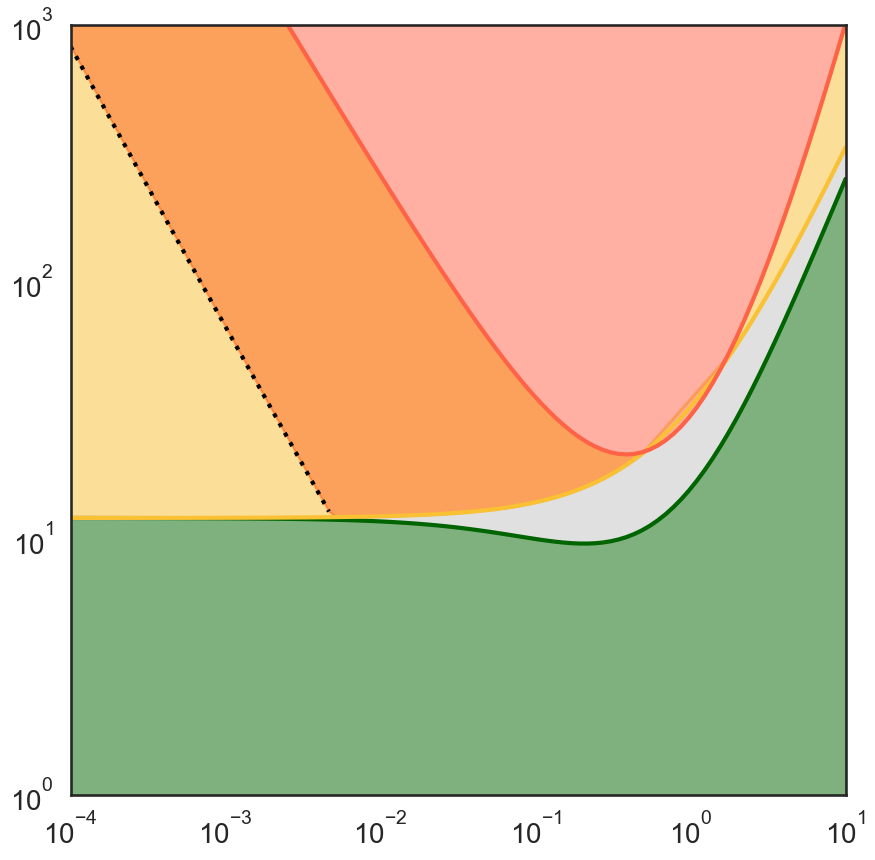

In [8]:
scaled_dbar = 0.3
R0 = 2.5
N=1e7
U = 1000/1e7



ycs = np.logspace(-4,1,100)
Es_total = E_total(ycs, R0, scaled_dbar)
Es_selection_driven = E_high(ycs, R0, scaled_dbar)
Es_exponential = E_low(ycs, R0, scaled_dbar)

fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(ycs, Es_total, label='Total',color='darkgreen')
ax.fill_between(ycs,1, Es_total, alpha=0.5, color='darkgreen')
ax.plot(ycs, Es_selection_driven, label='late mutants', color='#F9C133')
early_mutant_mask = np.logical_and(True, Es_selection_driven<Es_exponential)
ax.fill_between(ycs[early_mutant_mask],Es_selection_driven[early_mutant_mask], Es_exponential[early_mutant_mask], alpha=0.5, color='#F9C133')
ax.plot(ycs, Es_exponential, label='early mutants',color= 'tomato',)
ax.fill_between(ycs,Es_exponential,1e3, alpha=0.5, color='tomato')

ax.fill_between(ycs,Es_total,np.minimum(Es_selection_driven,Es_exponential), alpha=0.7, color='lightgrey')

# E_ci = scaled_dbar*N *np.array([find_U(yp,R0,scaled_dbar,N) for yp in ycs])
E_ci = scaled_dbar * 4/(3* ycs*np.log((4*ycs*np.sqrt(scaled_dbar/ycs))/(np.sqrt(3)*U)))
# E_ci = scaled_dbar * 4/(3* ycs)

ax.plot(ycs[E_ci > Es_total], E_ci[E_ci > Es_total], label='CI law', color='black', linestyle=':')

ci_fill_mask = np.logical_and(Es_exponential>=Es_selection_driven, ycs<1)

ax.fill_between(ycs[ci_fill_mask],
                 np.maximum(E_ci,Es_selection_driven)[ci_fill_mask],
                 np.minimum(2e3*np.ones_like(Es_total),Es_exponential)[ci_fill_mask], 
                 color='orangered', alpha=0.4)#, hatch='/',facecolor='none')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1e3)
ax.set_xlim([ycs[0],ycs[-1]])
# plt.savefig(output_folder+f'/fig2.1_invtest_R0{R0:.2f}_delta{scaled_dbar:.2f}.svg', bbox_inches='tight')

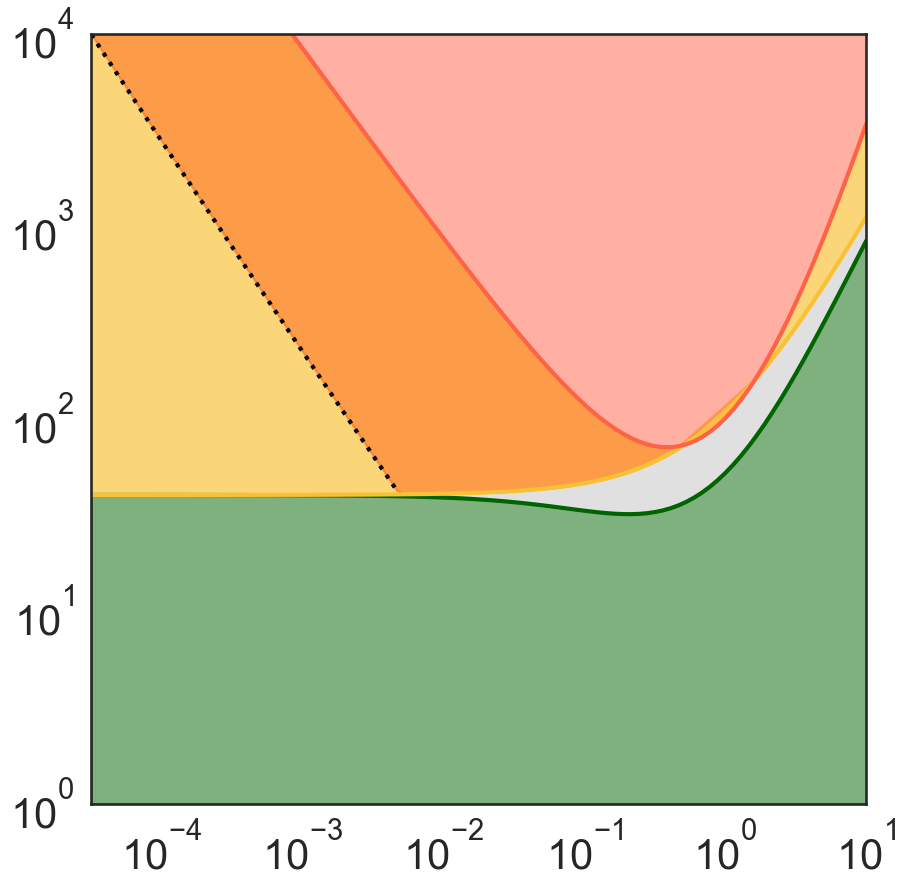

In [9]:
scaled_dbar = 0.3
R0 = 2.5
N=1e7
U = 1000/1e7



ycs = np.logspace(-4.5,1,100)
UNs_total = E_total(ycs, R0, scaled_dbar)/scaled_dbar
UNs_selection_driven = E_high(ycs, R0, scaled_dbar)/scaled_dbar
UNs_exponential = E_low(ycs, R0, scaled_dbar)/scaled_dbar

fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.plot(ycs, UNs_total, label='Total',color='darkgreen')
ax.fill_between(ycs,1, UNs_total, alpha=0.5, color='darkgreen')
ax.plot(ycs, UNs_selection_driven, label='late mutants', color='#F9C133')
early_mutant_mask = np.logical_and(True, UNs_selection_driven<UNs_exponential)
ax.fill_between(ycs[early_mutant_mask],UNs_selection_driven[early_mutant_mask], UNs_exponential[early_mutant_mask], alpha=0.66, color='#F9C133')
ax.plot(ycs, UNs_exponential, label='early mutants',color= 'tomato',)

ax.fill_between(ycs,UNs_total,np.minimum(UNs_selection_driven,UNs_exponential), alpha=0.7, color='lightgrey')

# UNs_ci = scaled_dbar*N *np.array([find_U(yp,R0,scaled_dbar,N) for yp in ycs])
UNs_ci = 4/(3* ycs*np.log((4*ycs*np.sqrt(scaled_dbar/ycs))/(np.sqrt(3)*U)))
# UNs_ci = scaled_dbar * 4/(3* ycs)

ax.plot(ycs[UNs_ci > UNs_total], UNs_ci[UNs_ci > UNs_total], label='CI law', color='black', ls=':')

ci_fill_mask = np.logical_and(UNs_exponential>=UNs_selection_driven, ycs<1)

top_ylim = ax.get_ylim()[1]

ax.fill_between(ycs,UNs_exponential,10* top_ylim, alpha=0.5, color='tomato')
ax.fill_between(ycs[ci_fill_mask],
                 np.maximum(UNs_ci,UNs_selection_driven)[ci_fill_mask],
                 np.minimum(10* top_ylim*np.ones_like(UNs_total),UNs_exponential)[ci_fill_mask], 
                 color='orangered', alpha=0.4)#, hatch='/',facecolor='none')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1,1e4)
ax.set_xlim([ycs[0],ycs[-1]])
ax.tick_params(axis='both', which='major', labelsize=30)

In [10]:
np.minimum(9e2*np.ones_like(Es_total),Es_exponential)[Es_exponential>=Es_selection_driven].shape

(90,)

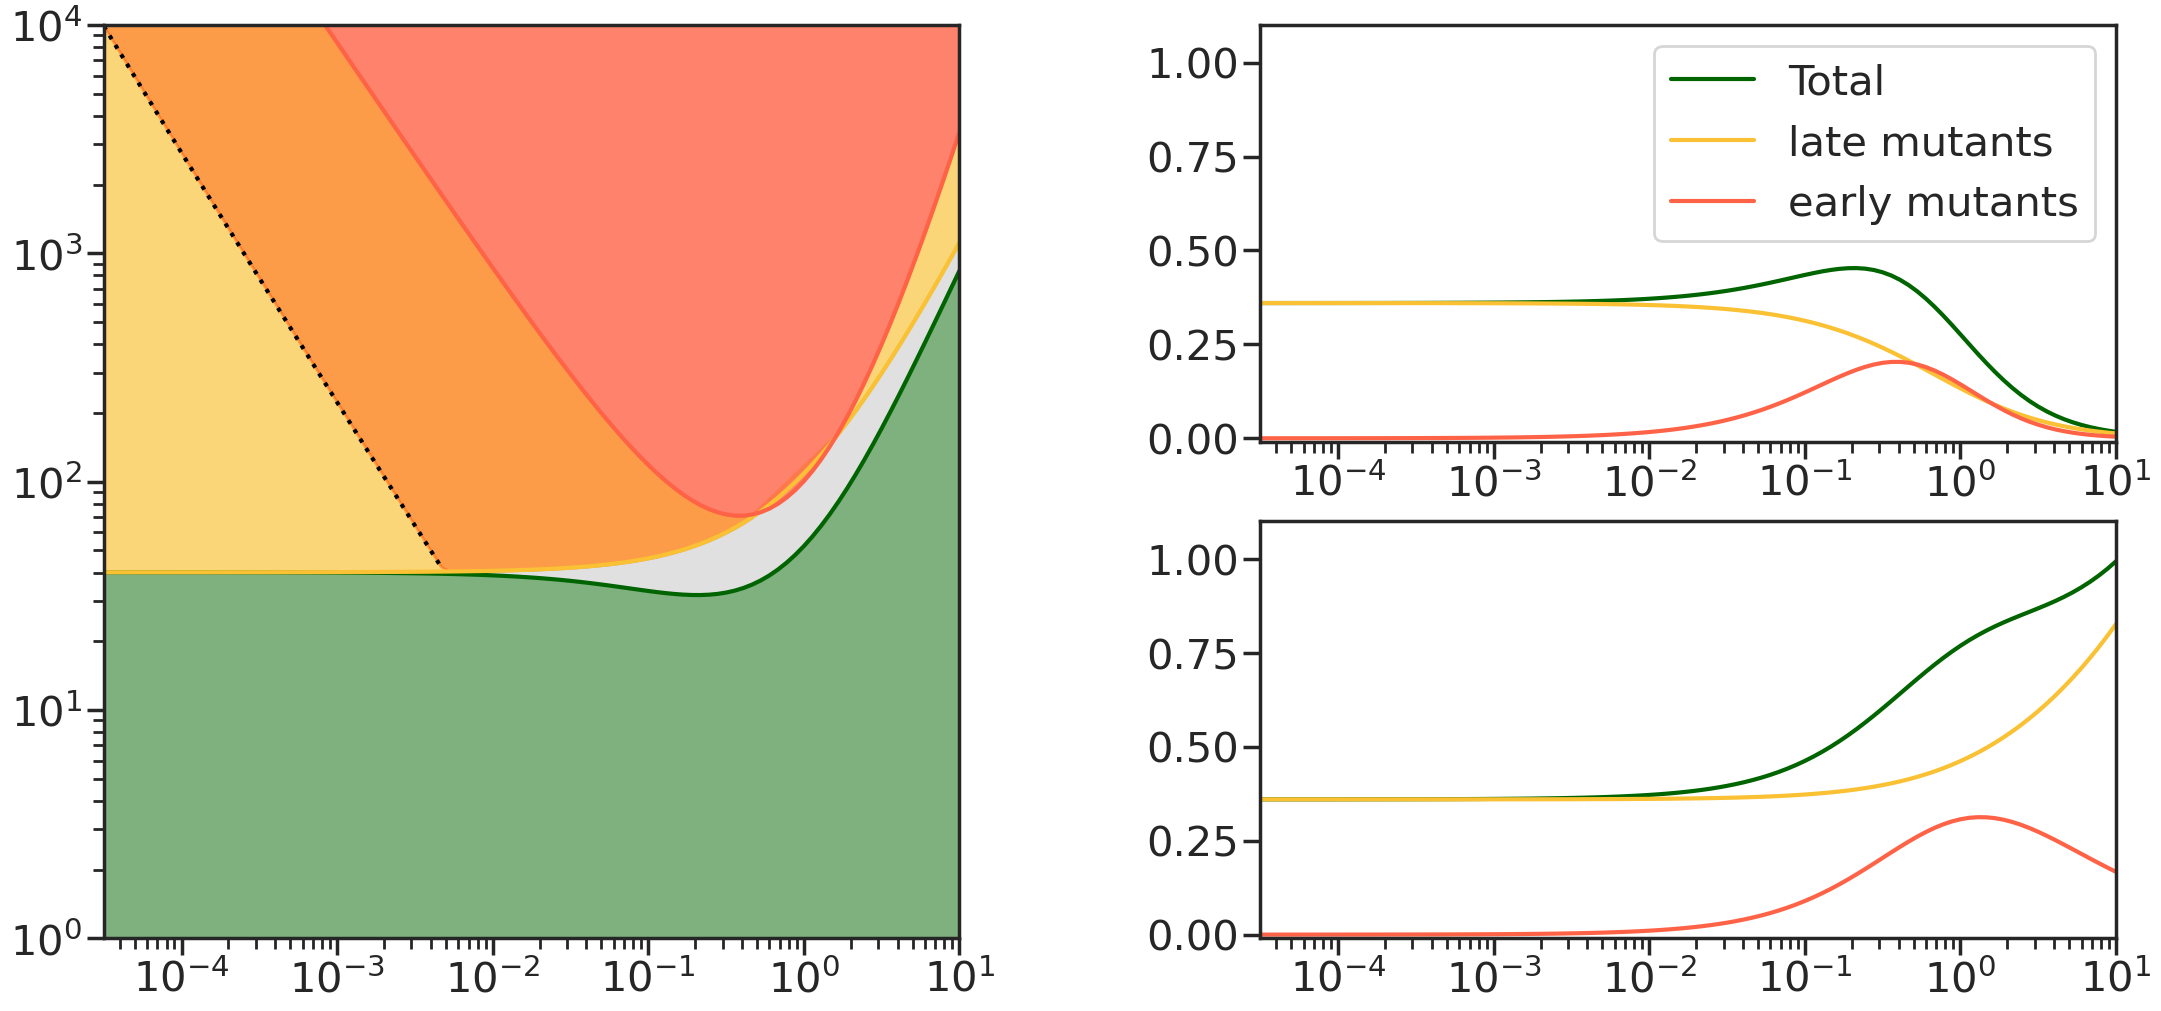

In [11]:
sns.set_theme(context = 'poster', style = 'ticks', font = 'DejaVu Sans')

small_delta = 0.3
big_delta = 0.6
R0 = 2.5
N=1e7
U = 1000/1e7

yc_star_small_delta = R0/(R0-1)**2 /small_delta
yc_star_big_delta = R0/(R0-1)**2 /big_delta

ycs = np.logspace(-4.5,1,100)
UNs_total = E_total(ycs, R0, small_delta)/small_delta
UNs_selection_driven = E_high(ycs, R0, small_delta)/small_delta
UNs_exponential = E_low(ycs, R0, small_delta)/small_delta

m_high_small_delta = m_func_high(ycs, R0, small_delta)
m_low_small_delta = m_func_low(ycs, R0, small_delta)
m_total_small_delta = m_func_total(ycs, R0, small_delta)

m_high_big_delta = m_func_high(ycs, R0, big_delta)
m_low_big_delta = m_func_low(ycs, R0, big_delta)
m_total_big_delta = m_func_total(ycs, R0, big_delta)

mosaic = """
AAAAAA.BBBBBB
AAAAAA.BBBBBB
AAAAAA.BBBBBB
AAAAAA.CCCCCC
AAAAAA.CCCCCC
AAAAAA.CCCCCC
"""

xs_small_delta = ycs/yc_star_small_delta
xs_big_delta = ycs/yc_star_big_delta

fig,axes = plt.subplot_mosaic(mosaic, layout='constrained',figsize=(21.5,10))

axes["A"].plot(ycs, UNs_total, label='Total',color='darkgreen')
axes["A"].fill_between(ycs,1, UNs_total, alpha=0.5, color='darkgreen')
axes["A"].plot(ycs, UNs_selection_driven, label='late mutants', color='#F9C133')
early_mutant_mask = np.logical_and(True, UNs_selection_driven<UNs_exponential)
axes["A"].fill_between(ycs[early_mutant_mask],UNs_selection_driven[early_mutant_mask], UNs_exponential[early_mutant_mask], alpha=0.66, color='#F9C133')
axes["A"].plot(ycs, UNs_exponential, label='early mutants',color= 'tomato',)

axes["A"].fill_between(ycs,UNs_total,np.minimum(UNs_selection_driven,UNs_exponential), alpha=0.7, color='lightgrey')

# UNs_ci = small_delta*N *np.array([find_U(yp,R0,small_delta,N) for yp in ycs])
UNs_ci = 4/(3* ycs*np.log((4*ycs*np.sqrt(small_delta/ycs))/(np.sqrt(3)*U)))
# UNs_ci = small_delta * 4/(3* ycs)

axes["A"].plot(ycs[UNs_ci > UNs_total], UNs_ci[UNs_ci > UNs_total], label='CI law', color='black', ls=':')

ci_fill_mask = np.logical_and(UNs_exponential>=UNs_selection_driven, ycs<1)

top_ylim = axes["A"].get_ylim()[1]

axes["A"].fill_between(ycs,UNs_exponential,10* top_ylim, alpha=0.8, color='tomato')
axes["A"].fill_between(ycs[ci_fill_mask],
                 np.maximum(UNs_ci,UNs_selection_driven)[ci_fill_mask],
                 np.minimum(10* top_ylim*np.ones_like(UNs_total),UNs_exponential)[ci_fill_mask], 
                 color='orangered', alpha=0.4)#, hatch='/',facecolor='none')

axes["A"].set_xscale('log')
axes["A"].set_yscale('log')
axes["A"].set_ylim(1,1e4)
axes["A"].set_xlim([ycs[0],ycs[-1]])
axes["A"].tick_params(axis='both', which='major', labelsize=30)

axes["B"].plot(ycs, m_total_small_delta/(small_delta/(1+small_delta)), label='Total',color='darkgreen')
axes["B"].plot(ycs, m_high_small_delta/(small_delta/(1+small_delta)), label='late mutants', color='#F9C133')
axes["B"].plot(ycs, m_low_small_delta/(small_delta/(1+small_delta)), label='early mutants',color= 'tomato',)

axes["B"].set_xscale('log')
# axes["B"].set_yticks(axes["B"].get_yticks()[::2])
# axes["B"].set_yscale('log')

axes["C"].plot(ycs, m_total_big_delta/(big_delta/(1+big_delta)), label='Total',color='darkgreen')
axes["C"].plot(ycs, m_high_big_delta/(big_delta/(1+big_delta)), label='late mutants', color='#F9C133')
axes["C"].plot(ycs, m_low_big_delta/(big_delta/(1+big_delta)), label='early mutants',color= 'tomato',)
axes["C"].set_xscale('log')

for ax in axes.values():
    ax.set_xlim([ycs[0],ycs[-1]])
    ax.tick_params(axis='both', which='major', labelsize=30)

for a in ["B","C"]:
    axes[a].set_ylim(-.01,1.1)
# axes["B"].set_yticks(axes["A"].get_yticks()[::)
axes["B"].legend(loc='upper right', fontsize=30)

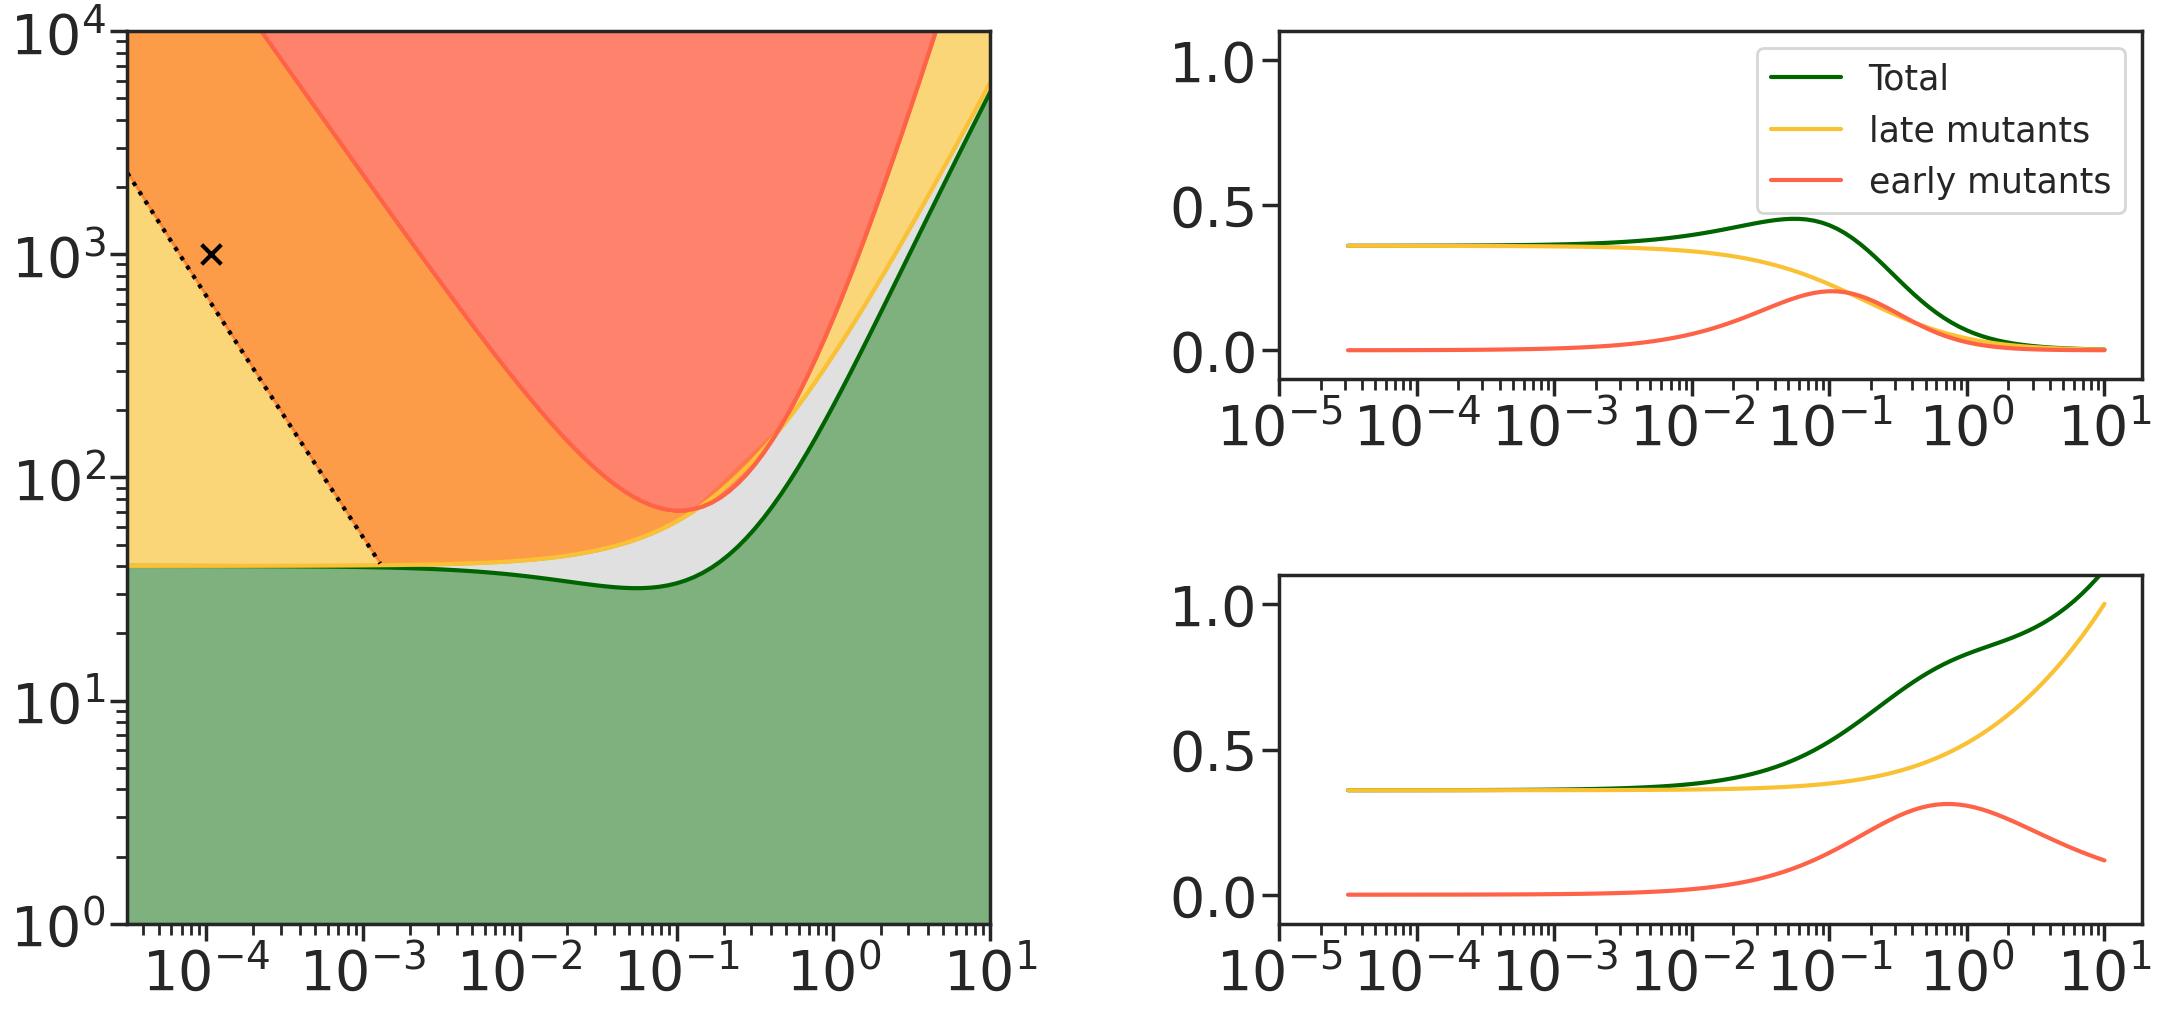

In [14]:
sns.set_theme(context = 'poster', style = 'ticks', font = 'DejaVu Sans')

small_delta = 0.3
big_delta = 0.6
R0 = 2.5
N=1e7
U = 1000/1e7

yc_star_small_delta = R0/(R0-1)**2 /small_delta
yc_star_big_delta = R0/(R0-1)**2 /big_delta

xs = np.logspace(-4.5,1,100)
ycs_small_delta = xs*yc_star_small_delta
ycs_big_delta = xs*yc_star_big_delta

ycs = np.logspace(-4.5,1,100)
UNs_total_small_delta = E_total(ycs_small_delta, R0, small_delta)/small_delta
UNs_selection_driven_small_delta = E_high(ycs_small_delta, R0, small_delta)/small_delta
UNs_exponential_big_delta = E_low(ycs_small_delta, R0, small_delta)/small_delta
UNs_ci = 4/(3* ycs_small_delta*np.log((4*ycs_small_delta*np.sqrt(small_delta/ycs_small_delta))/(np.sqrt(3)*U)))

m_high_small_delta = m_func_high(ycs_small_delta, R0, small_delta)
m_low_small_delta = m_func_low(ycs_small_delta, R0, small_delta)
m_total_small_delta = m_func_total(ycs_small_delta, R0, small_delta)

m_high_big_delta = m_func_high(ycs_big_delta, R0, big_delta)
m_low_big_delta = m_func_low(ycs_big_delta, R0, big_delta)
m_total_big_delta = m_func_total(ycs_big_delta, R0, big_delta)

mosaic = """
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA........
AAAAAAA.CCCCCCC
AAAAAAA.CCCCCCC
AAAAAAA.CCCCCCC
AAAAAAA.CCCCCCC
"""


fig,axes = plt.subplot_mosaic(mosaic, layout='constrained',figsize=(21.5,10))

axes["A"].plot(xs, UNs_total_small_delta, label='Total',color='darkgreen')
axes["A"].fill_between(xs,1, UNs_total_small_delta, alpha=0.5, color='darkgreen')
axes["A"].plot(xs, UNs_selection_driven_small_delta, label='late mutants', color='#F9C133')
early_mutant_mask = np.logical_and(True, UNs_selection_driven_small_delta<UNs_exponential_big_delta)
axes["A"].fill_between(xs[early_mutant_mask],UNs_selection_driven_small_delta[early_mutant_mask], UNs_exponential_big_delta[early_mutant_mask], alpha=0.66, color='#F9C133')
axes["A"].plot(xs, UNs_exponential_big_delta, label='early mutants',color= 'tomato',)

axes["A"].fill_between(xs,UNs_total_small_delta,np.minimum(UNs_selection_driven_small_delta,UNs_exponential_big_delta), alpha=0.7, color='lightgrey')

# UNs_ci = small_delta*N *np.array([find_U(yp,R0,small_delta,N) for yp in ycs_small_delta])
# UNs_ci = small_delta * 4/(3* ycs)

axes["A"].plot(xs[UNs_ci > UNs_total_small_delta], UNs_ci[UNs_ci > UNs_total_small_delta], label='CI law', color='black', ls=':')

ci_fill_mask = np.logical_and(UNs_exponential_big_delta>=UNs_selection_driven_small_delta, ycs_small_delta<1)

top_ylim = axes["A"].get_ylim()[1]

axes["A"].fill_between(xs,UNs_exponential_big_delta,10* top_ylim, alpha=0.8, color='tomato')
axes["A"].fill_between(xs[ci_fill_mask],
                 np.maximum(UNs_ci,UNs_selection_driven_small_delta)[ci_fill_mask],
                 np.minimum(10* top_ylim*np.ones_like(UNs_total_small_delta),UNs_exponential_big_delta)[ci_fill_mask], 
                 color='orangered', alpha=0.4)#, hatch='/',facecolor='none')

axes["A"].set_xscale('log')
axes["A"].set_yscale('log')
axes["A"].set_ylim(1,5e2)
axes["A"].set_xlim([xs[0],xs[-1]])
axes["A"].tick_params(axis='both', which='major', labelsize=30)

axes["B"].plot(xs, m_total_small_delta/(small_delta/(1+small_delta)), label='Total',color='darkgreen')
axes["B"].plot(xs, m_high_small_delta/(small_delta/(1+small_delta)), label='late mutants', color='#F9C133')
axes["B"].plot(xs, m_low_small_delta/(small_delta/(1+small_delta)), label='early mutants',color= 'tomato',)

axes["B"].set_xscale('log')
# axes["B"].set_yticks(axes["B"].get_yticks()[::2])
# axes["B"].set_yscale('log')

axes["C"].plot(xs, m_total_big_delta/(big_delta/(1+big_delta)), label='Total',color='darkgreen')
axes["C"].plot(xs, m_high_big_delta/(big_delta/(1+big_delta)), label='late mutants', color='#F9C133')
axes["C"].plot(xs, m_low_big_delta/(big_delta/(1+big_delta)), label='early mutants',color= 'tomato',)
axes["C"].set_xscale('log')
# for a in ["B","C"]:

    # ax.set_xticks()

for a in ["B","C"]:
    axes[a].set_ylim(-.1,1.1)
# axes["B"].set_yticks(axes["A"].get_yticks()[::)
axes["B"].legend(loc='upper right', fontsize=25)

xlim_left = np.min((axes["C"].get_xlim()[0],axes["B"].get_xlim()[0]))
xlim_right = np.max((axes["C"].get_xlim()[1],axes["B"].get_xlim()[1]))

for a in ["B","C"]:
    axes[a].set_xlim([xlim_left,xlim_right])

from matplotlib.ticker import LogLocator

for a in axes:
    xticks= axes[a].get_xticks()
    yticks= axes[a].get_yticks()    
    axes[a].tick_params(axis='both', which='major', labelsize=40)
    if a=='A':
        axes[a].set_xticks(xticks[2:-1])
        axes[a].set_yticks(yticks[1:])
    else:
        axes[a].set_xticks(xticks[1:-2:1])
        axes[a].set_yticks(yticks[1::2])
    #fix minor ticks
    axes[a].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=100))

#mark position at UN = 1000, y = 4 \times 10^{-4}, delta = 0.3
yc_sars = 4e-4
yc_sars_small_delta = yc_sars/yc_star_small_delta

UN_sars = 1000
axes["A"].scatter(yc_sars_small_delta, UN_sars, color='black', s=200, marker='x')

plt.savefig(output_folder+f'/fig2.4_invtest_R0{R0:.2f}_delta{small_delta:.2f}.svg', bbox_inches='tight')


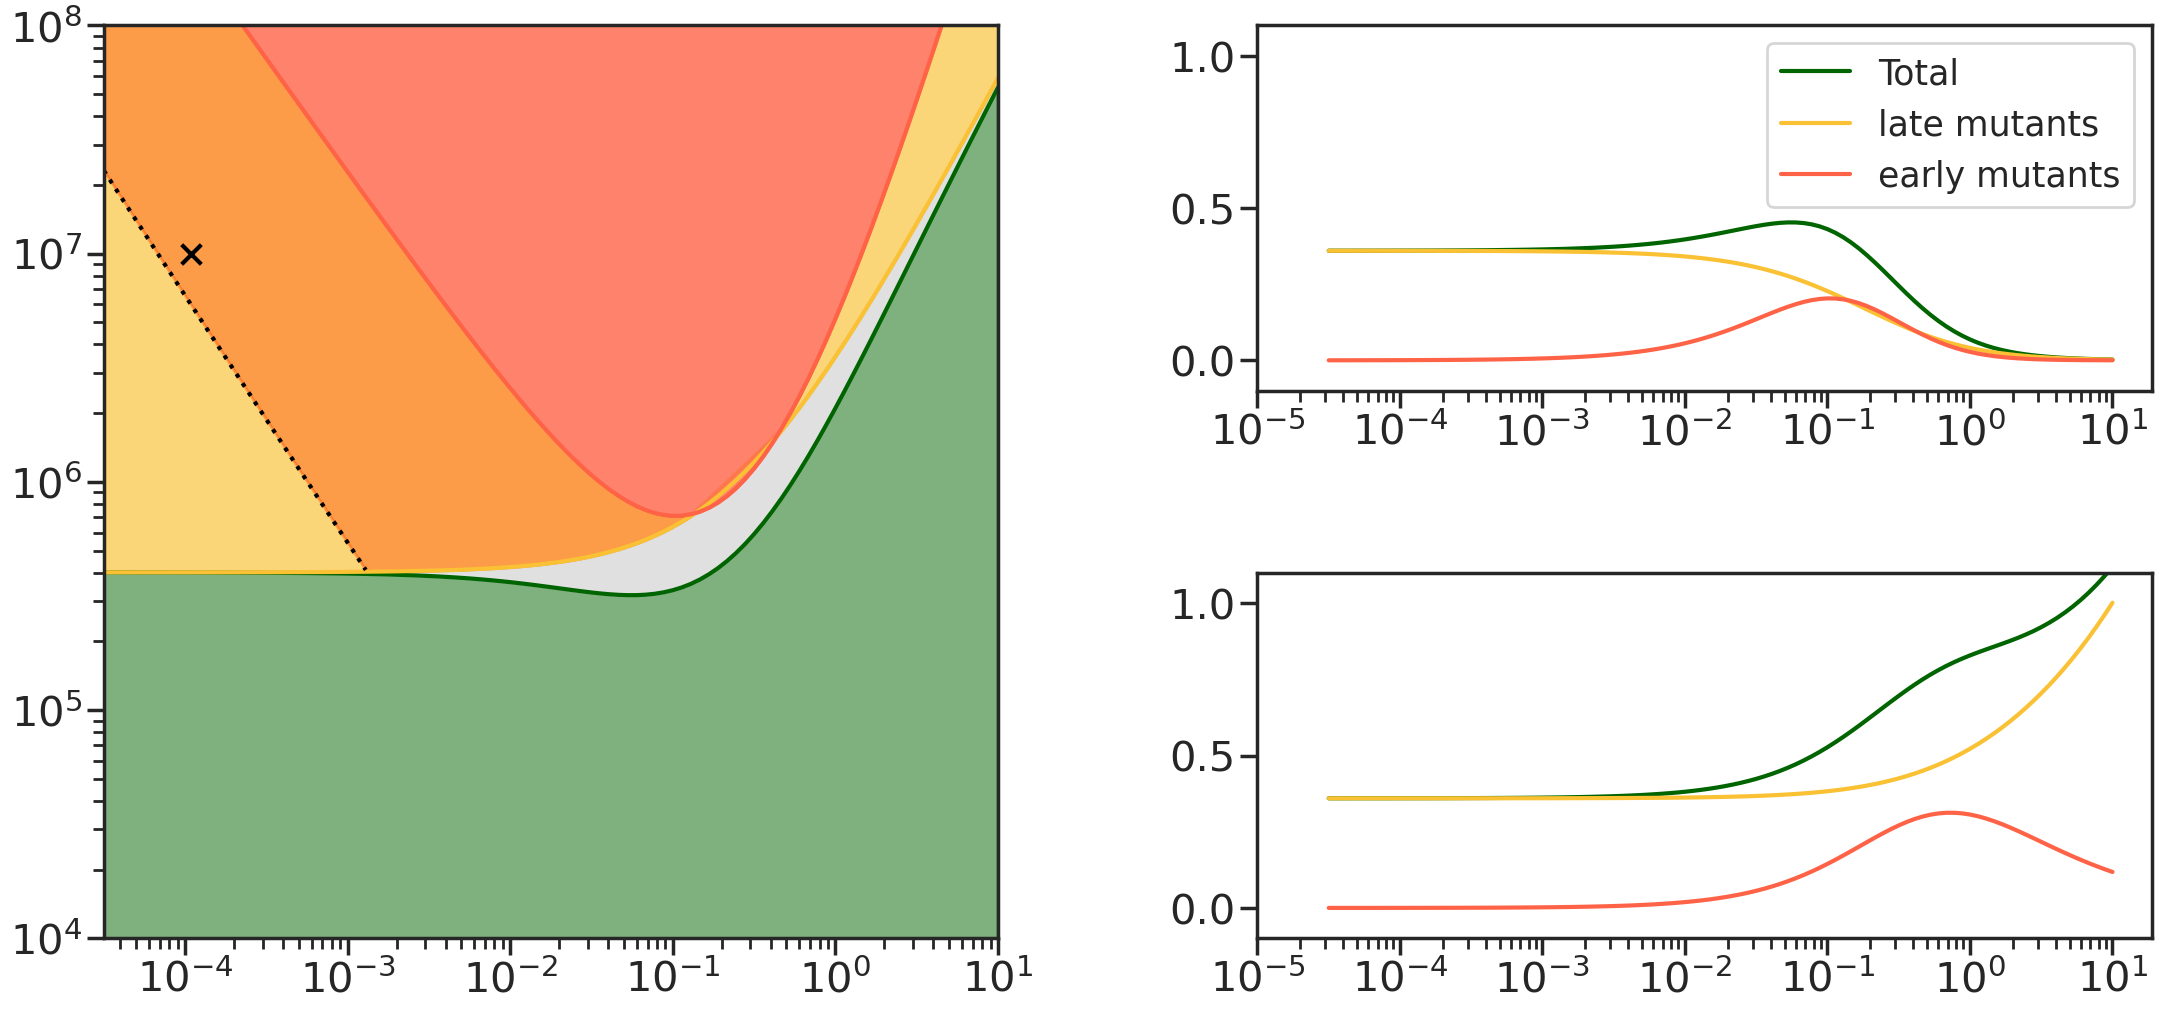

In [15]:
sns.set_theme(context = 'poster', style = 'ticks', font = 'DejaVu Sans')

small_delta = 0.3
big_delta = 0.6
R0 = 2.5
N=1e7
U = 1e-4

yc_star_small_delta = R0/(R0-1)**2 /small_delta
yc_star_big_delta = R0/(R0-1)**2 /big_delta

xs = np.logspace(-4.5,1,100)
ycs_small_delta = xs*yc_star_small_delta
ycs_big_delta = xs*yc_star_big_delta

ycs = np.logspace(-4.5,1,100)

UNs_total_small_delta = E_total(ycs_small_delta, R0, small_delta)/small_delta
UNs_selection_driven_small_delta = E_high(ycs_small_delta, R0, small_delta)/small_delta
UNs_exponential_small_delta = E_low(ycs_small_delta, R0, small_delta)/small_delta
UNs_ci = 4/(3* ycs_small_delta*np.log((4*ycs_small_delta*np.sqrt(small_delta/ycs_small_delta))/(np.sqrt(3)*U)))

N_crits_total_small_delta = UNs_total_small_delta/U
N_crits_selection_driven_small_delta = UNs_selection_driven_small_delta/U
N_crits_exponential_big_delta = UNs_exponential_small_delta/U
N_crits_ci = UNs_ci/U



m_high_small_delta = m_func_high(ycs_small_delta, R0, small_delta)
m_low_small_delta = m_func_low(ycs_small_delta, R0, small_delta)
m_total_small_delta = m_func_total(ycs_small_delta, R0, small_delta)

m_high_big_delta = m_func_high(ycs_big_delta, R0, big_delta)
m_low_big_delta = m_func_low(ycs_big_delta, R0, big_delta)
m_total_big_delta = m_func_total(ycs_big_delta, R0, big_delta)

mosaic = """
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA........
AAAAAAA.CCCCCCC
AAAAAAA.CCCCCCC
AAAAAAA.CCCCCCC
AAAAAAA.CCCCCCC
"""


fig,axes = plt.subplot_mosaic(mosaic, layout='constrained',figsize=(21.5,10))

axes["A"].plot(xs, N_crits_total_small_delta, label='Total',color='darkgreen')
axes["A"].fill_between(xs,1, N_crits_total_small_delta, alpha=0.5, color='darkgreen')
axes["A"].plot(xs, N_crits_selection_driven_small_delta, label='late mutants', color='#F9C133')
early_mutant_mask = np.logical_and(True, N_crits_selection_driven_small_delta<N_crits_exponential_big_delta)
axes["A"].fill_between(xs[early_mutant_mask],N_crits_selection_driven_small_delta[early_mutant_mask], N_crits_exponential_big_delta[early_mutant_mask], alpha=0.66, color='#F9C133')
axes["A"].plot(xs, N_crits_exponential_big_delta, label='early mutants',color= 'tomato',)

axes["A"].fill_between(xs,N_crits_total_small_delta,np.minimum(N_crits_selection_driven_small_delta,N_crits_exponential_big_delta), alpha=0.7, color='lightgrey')

# N_crits_ci = small_delta*N *np.array([find_U(yp,R0,small_delta,N) for yp in ycs_small_delta])
# N_crits_ci = small_delta * 4/(3* ycs)

axes["A"].plot(xs[N_crits_ci > N_crits_total_small_delta], N_crits_ci[N_crits_ci > N_crits_total_small_delta], label='CI law', color='black', ls=':')

ci_fill_mask = np.logical_and(N_crits_exponential_big_delta>=N_crits_selection_driven_small_delta, ycs_small_delta<1)

top_ylim = axes["A"].get_ylim()[1]

axes["A"].fill_between(xs,N_crits_exponential_big_delta,10* top_ylim, alpha=0.8, color='tomato')
axes["A"].fill_between(xs[ci_fill_mask],
                 np.maximum(N_crits_ci,N_crits_selection_driven_small_delta)[ci_fill_mask],
                 np.minimum(10* top_ylim*np.ones_like(N_crits_total_small_delta),N_crits_exponential_big_delta)[ci_fill_mask], 
                 color='orangered', alpha=0.4)#, hatch='/',facecolor='none')

axes["A"].set_xscale('log')
axes["A"].set_yscale('log')
axes["A"].set_ylim(1/U,5e2/U)
axes["A"].set_xlim([xs[0],xs[-1]])
axes["A"].tick_params(axis='both', which='major', labelsize=30)

axes["B"].plot(xs, m_total_small_delta/(small_delta/(1+small_delta)), label='Total',color='darkgreen')
axes["B"].plot(xs, m_high_small_delta/(small_delta/(1+small_delta)), label='late mutants', color='#F9C133')
axes["B"].plot(xs, m_low_small_delta/(small_delta/(1+small_delta)), label='early mutants',color= 'tomato',)



axes["B"].set_xscale('log')
# axes["B"].set_yticks(axes["B"].get_yticks()[::2])
# axes["B"].set_yscale('log')

axes["C"].plot(xs, m_total_big_delta/(big_delta/(1+big_delta)), label='Total',color='darkgreen')
axes["C"].plot(xs, m_high_big_delta/(big_delta/(1+big_delta)), label='late mutants', color='#F9C133')
axes["C"].plot(xs, m_low_big_delta/(big_delta/(1+big_delta)), label='early mutants',color= 'tomato',)



axes["C"].set_xscale('log')
# for a in ["B","C"]:

    # ax.set_xticks()

for a in ["B","C"]:
    axes[a].set_ylim(-.1,1.1)
# axes["B"].set_yticks(axes["A"].get_yticks()[::)
axes["B"].legend(loc='upper right', fontsize=25)

xlim_left = np.min((axes["C"].get_xlim()[0],axes["B"].get_xlim()[0]))
xlim_right = np.max((axes["C"].get_xlim()[1],axes["B"].get_xlim()[1]))

for a in ["B","C"]:
    axes[a].set_xlim([xlim_left,xlim_right])

from matplotlib.ticker import LogLocator

for a in axes:
    xticks= axes[a].get_xticks()
    yticks= axes[a].get_yticks()    
    axes[a].tick_params(axis='both', which='major', labelsize=30)
    if a=='A':
        axes[a].set_xticks(xticks[2:-1])
        axes[a].set_yticks(yticks[1:])
    else:
        axes[a].set_xticks(xticks[1:-2:1])
        axes[a].set_yticks(yticks[1::2])
    #fix minor ticks
    axes[a].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=100))

#mark position at UN = 1000, y = 4 \times 10^{-4}, delta = 0.3
yc_sars = 4e-4
yc_sars_small_delta = yc_sars/yc_star_small_delta

UN_sars = 1000
axes["A"].scatter(yc_sars_small_delta, UN_sars/U, color='black', s=200, marker='x')

plt.savefig(output_folder+f'/fig2_Ncrit_invtest_R0{R0:.2f}_delta{small_delta:.2f}.svg', bbox_inches='tight')

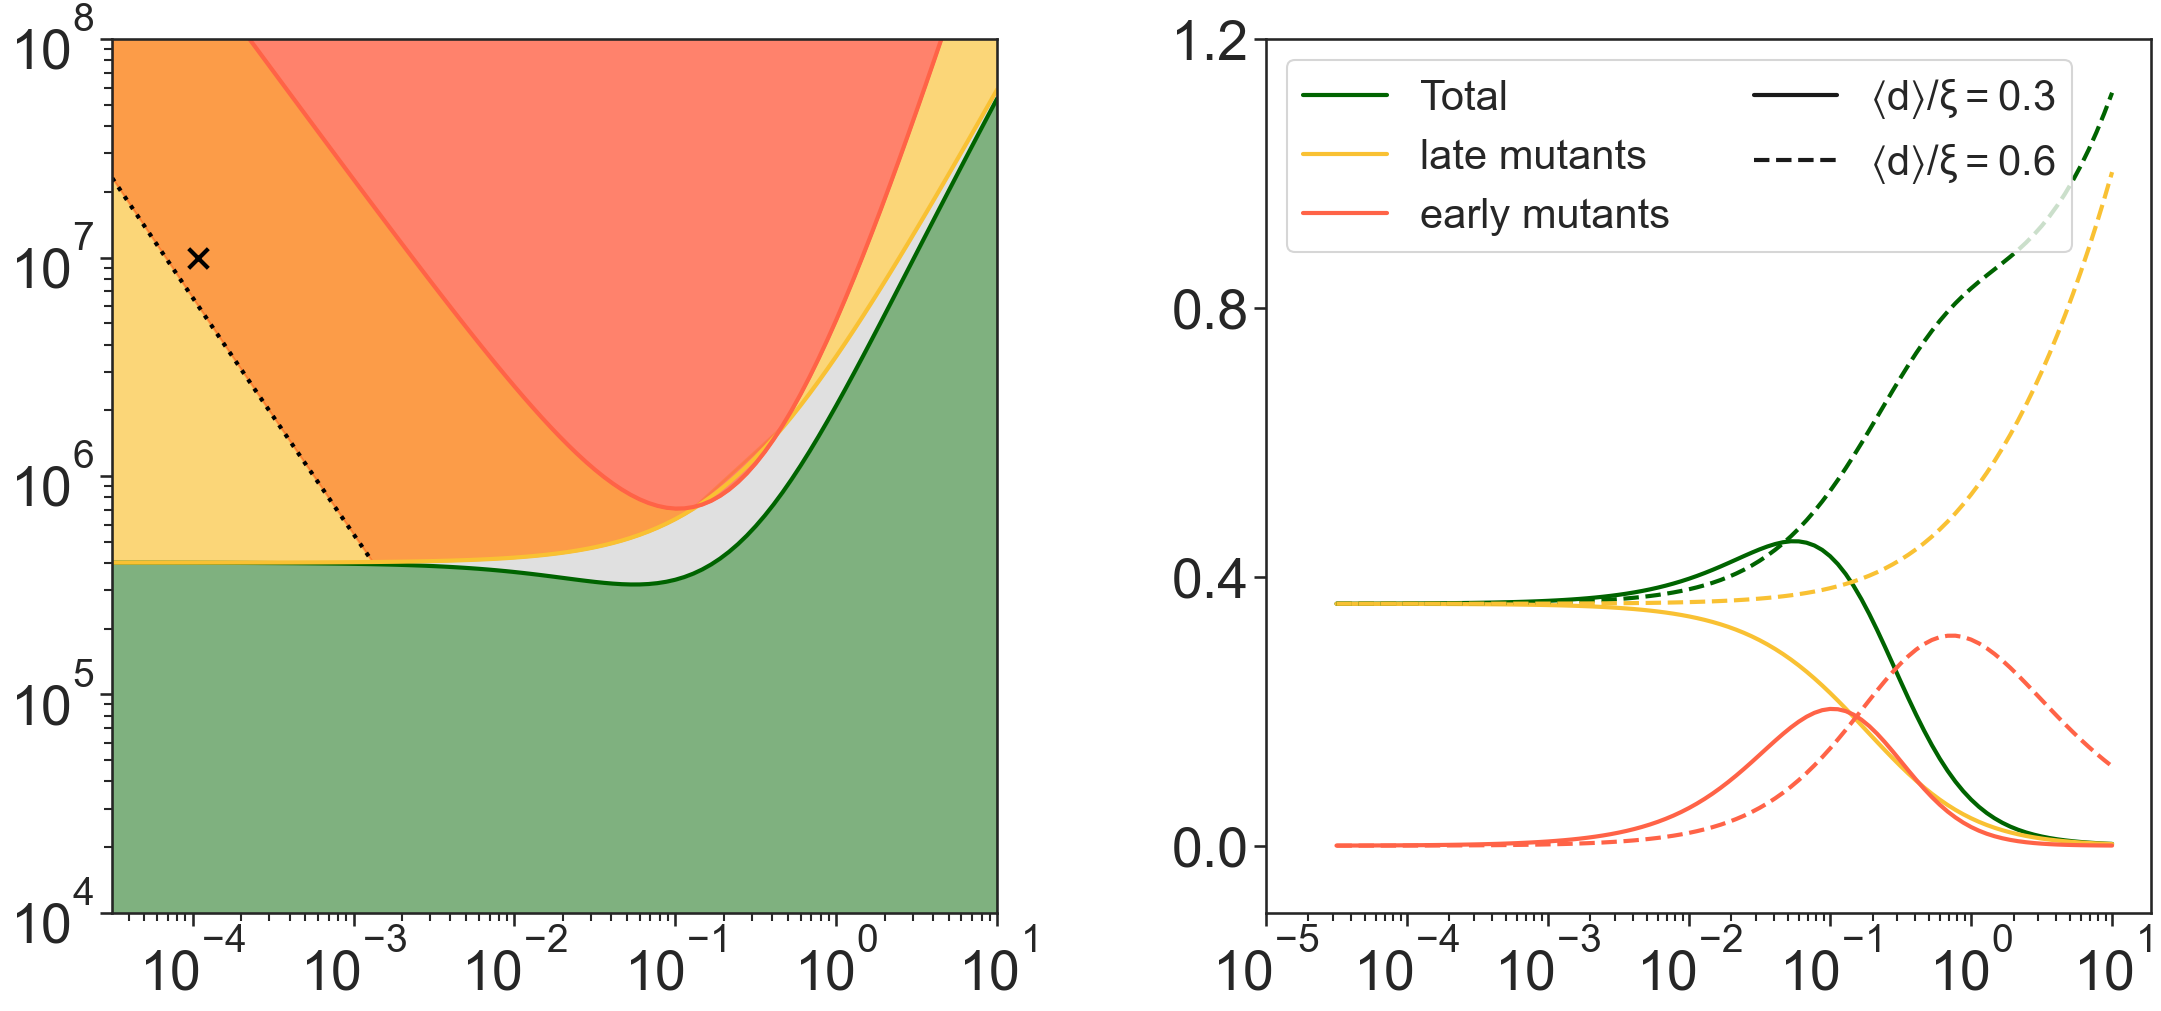

In [133]:
# sns.set_theme(context='paper')
sns.set_style("ticks")
plt.rc('mathtext', default='regular')
#import Line2D
from matplotlib.lines import Line2D
small_delta = 0.3
big_delta = 0.6
R0 = 2.5
N=1e7
U = 1e-4

yc_star_small_delta = R0/(R0-1)**2 /(small_delta)
yc_star_big_delta = R0/(R0-1)**2 /(big_delta)

xs = np.logspace(-4.5,1,100)
ycs_small_delta = xs*yc_star_small_delta
ycs_big_delta = xs*yc_star_big_delta

ycs = np.logspace(-4.5,1,100)

UNs_total_small_delta = E_total(ycs_small_delta, R0, small_delta)/small_delta
UNs_selection_driven_small_delta = E_high(ycs_small_delta, R0, small_delta)/small_delta
UNs_exponential_small_delta = E_low(ycs_small_delta, R0, small_delta)/small_delta
UNs_ci = 4/(3* ycs_small_delta*np.log((4*ycs_small_delta*np.sqrt(small_delta/ycs_small_delta))/(np.sqrt(3)*U)))

N_crits_total_small_delta = UNs_total_small_delta/U
N_crits_selection_driven_small_delta = UNs_selection_driven_small_delta/U
N_crits_exponential_big_delta = UNs_exponential_small_delta/U
N_crits_ci = UNs_ci/U



m_high_small_delta = m_func_high(ycs_small_delta, R0, small_delta)
m_low_small_delta = m_func_low(ycs_small_delta, R0, small_delta)
m_total_small_delta = m_func_total(ycs_small_delta, R0, small_delta)

m_high_big_delta = m_func_high(ycs_big_delta, R0, big_delta)
m_low_big_delta = m_func_low(ycs_big_delta, R0, big_delta)
m_total_big_delta = m_func_total(ycs_big_delta, R0, big_delta)

mosaic = """
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
AAAAAAA.BBBBBBB
"""


fig,axes = plt.subplot_mosaic(mosaic, layout='constrained',figsize=(21.5,10))

axes["A"].plot(xs, N_crits_total_small_delta, label='Total',color='darkgreen')
axes["A"].fill_between(xs,1, N_crits_total_small_delta, alpha=0.5, color='darkgreen')
axes["A"].plot(xs, N_crits_selection_driven_small_delta, label='late mutants', color='#F9C133')
early_mutant_mask = np.logical_and(True, N_crits_selection_driven_small_delta<N_crits_exponential_big_delta)
axes["A"].fill_between(xs[early_mutant_mask],N_crits_selection_driven_small_delta[early_mutant_mask], N_crits_exponential_big_delta[early_mutant_mask], alpha=0.66, color='#F9C133')
axes["A"].plot(xs, N_crits_exponential_big_delta, label='early mutants',color= 'tomato',)

axes["A"].fill_between(xs,N_crits_total_small_delta,np.minimum(N_crits_selection_driven_small_delta,N_crits_exponential_big_delta), alpha=0.7, color='lightgrey')

# N_crits_ci = small_delta*N *np.array([find_U(yp,R0,small_delta,N) for yp in ycs_small_delta])
# N_crits_ci = small_delta * 4/(3* ycs)

axes["A"].plot(xs[N_crits_ci > N_crits_total_small_delta], N_crits_ci[N_crits_ci > N_crits_total_small_delta], label='CI law', color='black', ls=':')

ci_fill_mask = np.logical_and(N_crits_exponential_big_delta>=N_crits_selection_driven_small_delta, ycs_small_delta<1)

top_ylim = axes["A"].get_ylim()[1]

axes["A"].fill_between(xs,N_crits_exponential_big_delta,10* top_ylim, alpha=0.8, color='tomato')
axes["A"].fill_between(xs[ci_fill_mask],
                 np.maximum(N_crits_ci,N_crits_selection_driven_small_delta)[ci_fill_mask],
                 np.minimum(10* top_ylim*np.ones_like(N_crits_total_small_delta),N_crits_exponential_big_delta)[ci_fill_mask], 
                 color='orangered', alpha=0.4)#, hatch='/',facecolor='none')

axes["A"].set_xscale('log')
axes["A"].set_yscale('log')
axes["A"].set_ylim(1/U,5e2/U)
axes["A"].set_xlim([xs[0],xs[-1]])
axes["A"].tick_params(axis='both', which='major', labelsize=30)

axes["B"].plot(xs, m_total_small_delta/(small_delta/(1+small_delta)), label='Total',color='darkgreen')
axes["B"].plot(xs, m_high_small_delta/(small_delta/(1+small_delta)), label='late mutants', color='#F9C133')
axes["B"].plot(xs, m_low_small_delta/(small_delta/(1+small_delta)), label='early mutants',color= 'tomato',)

axes["B"].plot(xs, m_total_big_delta/(big_delta/(1+big_delta)) ,color='darkgreen',ls = '--')
axes["B"].plot(xs, m_high_big_delta/(big_delta/(1+big_delta)), color='#F9C133',ls = '--')
axes["B"].plot(xs, m_low_big_delta/(big_delta/(1+big_delta)), color= 'tomato',ls = '--')


axes["B"].set_xscale('log')
# axes["B"].set_yticks(axes["B"].get_yticks()[::2])
# axes["B"].set_yscale('log')

# axes["C"].plot(xs, m_total_big_delta/(big_delta/(1+big_delta)), label='Total',color='darkgreen')
# axes["C"].plot(xs, m_high_big_delta/(big_delta/(1+big_delta)), label='late mutants', color='#F9C133')
# axes["C"].plot(xs, m_low_big_delta/(big_delta/(1+big_delta)), label='early mutants',color= 'tomato',)



# axes["C"].set_xscale('log')
# for a in ["B","C"]:

    # ax.set_xticks()

# for a in ["B","C"]:
for a in ["B"]:
    axes[a].set_ylim(-.1,1.1)
# axes["B"].set_yticks(axes["A"].get_yticks()[::)
handles, labels = axes["B"].get_legend_handles_labels()
handles += [Line2D([0], [0], color='k', ls='-'), Line2D([0], [0], color='k', ls='--')]
labels += [r"$\langle d \rangle /\xi = 0.3$", r"$\langle d \rangle /\xi = 0.6$"]
axes["B"].legend(handles=handles, labels=labels, loc='upper left', fontsize=30,ncol=2)

# xlim_left = np.min((axes["C"].get_xlim()[0],axes["B"].get_xlim()[0]))
# xlim_right = np.max((axes["C"].get_xlim()[1],axes["B"].get_xlim()[1]))

# for a in ["B","C"]:
#     axes[a].set_xlim([xlim_left,xlim_right])

from matplotlib.ticker import LogLocator

for a in axes:
    xticks= axes[a].get_xticks()
    yticks= axes[a].get_yticks()    
    axes[a].tick_params(axis='both', which='major', labelsize=40)
    if a=='A':
        axes[a].set_xticks(xticks[2:-1])
        axes[a].set_yticks(yticks[1:])
    else:
        axes[a].set_xticks(xticks[1:-2:1])
        axes[a].set_yticks(yticks[1::2])
    #fix minor ticks
    axes[a].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10), numticks=100))

#mark position at UN = 1000, y = 4 \times 10^{-4}, delta = 0.3
yc_sars = 4e-4
yc_sars_small_delta = yc_sars/yc_star_small_delta

UN_sars = 1000
axes["A"].scatter(yc_sars_small_delta, UN_sars/U, color='black', s=200, marker='x')

plt.savefig(output_folder+f'/fig22_Ncrit_invtest_R0{R0:.2f}_delta{small_delta:.2f}.svg', bbox_inches='tight')

In [74]:
xticks

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])

In [46]:
from lxml import etree

def scale_g_in_text(svg_path, out_path, scale=1.2, group_prefix="g"):
    tree = etree.parse(svg_path)
    root = tree.getroot()
    ns = {'svg': root.nsmap.get(None, '')}

    # find all <g> children of <text> where id starts with prefix
    xpath_expr = f".//svg:text/svg:g[starts-with(@id, '{group_prefix}')]"
    groups = root.xpath(xpath_expr, namespaces=ns)

    for g in groups:
        existing = g.attrib.get("transform", "")
        new_transform = f"scale({scale})"
        if existing:
            new_transform = f"{existing} {new_transform}"
        g.attrib["transform"] = new_transform

    tree.write(out_path)

# usage
in_path = output_folder+f'/fig2.3_invtest_R0{R0:.2f}_delta1{small_delta:.2f}_delta2{big_delta:.2f}.svg'
out_path = output_folder+f'/fig2.3_invtest_R0{R0:.2f}_delta1{small_delta:.2f}_delta2{big_delta:.2f}_scaled.svg'
scale_g_in_text(in_path, out_path, scale=1.2, group_prefix="g")

In [37]:
tree = etree.parse(in_path)

root = tree.getroot()
ns = {'svg': root.nsmap.get(None, '')}  # handle default ns

In [38]:
ns

{'svg': 'http://www.w3.org/2000/svg'}

In [44]:
for elem in tree.iter():
    if elem.tag.endswith('text'):
        print(elem.tag, elem.text)
    # elif elem.tag.endswith('path'):
    #     print(elem.tag, elem.attrib)
    else:
        continue

AttributeError: '_cython_3_0_11.cython_function_or_method' object has no attribute 'endswith'